## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
dataset='/content/drive/MyDrive/Retail Sales Time Series Forecasting/feature_engineering/feature_engineering.csv'
df=pd.read_csv(dataset)
df.drop('Date',axis=1,inplace=True)
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Open_0,Open_1,Promo2_0,Promo2_1,SchoolHoliday_0,SchoolHoliday_1,StoreType_a,StoreType_b,StoreType_c,StoreType_d,PromoInterval_0,PromoInterval_Feb_May_Aug_Nov,PromoInterval_Jan_Apr_Jul_Oct,PromoInterval_Mar_Jun_Sept_Dec,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,date_year,date_weekofyear,date_month,date_dayofweek,date_day
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,4,5263,555,1,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,2015,31,7,4,31
1,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,3,5020,546,1,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,2015,31,7,3,30
2,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2,4782,523,1,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,2015,31,7,2,29
3,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,1,5011,560,1,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,2015,31,7,1,28
4,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,6102,612,1,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,2015,31,7,0,27


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 40 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Store                           1017209 non-null  int64  
 1   StoreType                       1017209 non-null  int64  
 2   Assortment                      1017209 non-null  int64  
 3   CompetitionDistance             1017209 non-null  float64
 4   CompetitionOpenSinceMonth       1017209 non-null  float64
 5   CompetitionOpenSinceYear        1017209 non-null  float64
 6   Promo2                          1017209 non-null  int64  
 7   Promo2SinceWeek                 1017209 non-null  float64
 8   Promo2SinceYear                 1017209 non-null  float64
 9   PromoInterval                   1017209 non-null  int64  
 10  DayOfWeek                       1017209 non-null  int64  
 11  Sales                           1017209 non-null  int64  
 12  

# Normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

norm = MinMaxScaler()

#norm = StandardScaler()
CompetitionDistance=norm.fit_transform(df[['CompetitionDistance','Sales']].values)[:,0]
Customers=norm.fit_transform(df[['Customers','Sales']].values)[:,0]

In [7]:
df['CompetitionDistance']=CompetitionDistance
df['Customers']=Customers

In [8]:
y=df['Sales']
X=df.drop('Sales',axis=1)

In [9]:
print(X.shape)

(1017209, 39)


In [10]:
def adjusted_r2(x_test,r2):
    return 1-(1-r2)*((len(x_test)-1)/(len(x_test)-x_test.shape[1]-1))

In [11]:
#accuracy dataframe that store accuracy of models
accuracy=pd.DataFrame(columns=['Train Adjusted R2','Test Adjusted R2'])

# Feature Selection

In [12]:
#X=df[cols8+['Sales']].copy()
X=df.copy()
y=df['Sales'].values
X.drop(['Sales'],axis=1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(813767, 39)
(203442, 39)


In [13]:
from sklearn.feature_selection import SelectFromModel
sel_ = SelectFromModel(linear_model.Lasso(alpha=0.1),max_features=20)
sel_.fit(X, y)

SelectFromModel(estimator=Lasso(alpha=0.1, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=None,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=20, norm_order=1, prefit=False, threshold=None)

In [14]:
selected_feat = X.columns[(sel_.get_support())]

In [15]:
selected_feat

Index(['Assortment', 'CompetitionDistance', 'PromoInterval', 'DayOfWeek',
       'Customers', 'Open', 'Promo', 'SchoolHoliday', 'Promo2_0',
       'StoreType_b', 'StoreType_c', 'StoreType_d',
       'PromoInterval_Mar_Jun_Sept_Dec', 'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c', 'date_year', 'date_month',
       'date_dayofweek'],
      dtype='object')

# ML Models

## 1. Lasso Regressor

In [16]:
#split dataset for selected features
X_train, X_test, y_train, y_test = train_test_split(X[selected_feat], y, test_size=0.2, random_state=42)

In [17]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(813767, 20) (813767,)
(203442, 20) (203442,)


In [18]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

train_adj_r2_score=round(adjusted_r2(X_train,clf.score(X_train,y_train)),4)
test_adj_r2_score=round(adjusted_r2(X_test,clf.score(X_test,y_test)),4)

print("Train Adj R2 = ",train_adj_r2_score)

print("Test Adj R2 = ",test_adj_r2_score)

Train Adj R2 =  0.8955
Test Adj R2 =  0.8967


In [19]:
accuracy.loc['LassoRegression']=[train_adj_r2_score,test_adj_r2_score]
print(accuracy)

                 Train Adjusted R2  Test Adjusted R2
LassoRegression             0.8955            0.8967


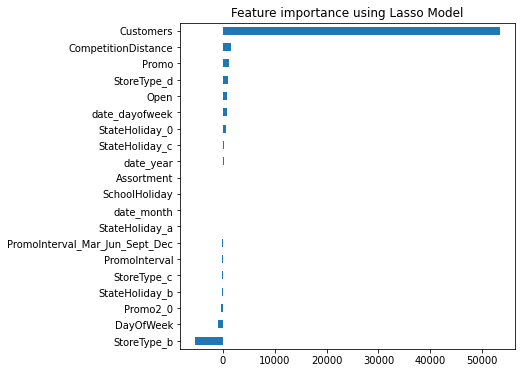

In [20]:
#Visualization of Feature Importance

coef = pd.Series(clf.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
#plt.savefig('Ridge-Regression-Feature-Importance.jpg')
plt.show()

## 2. Random Forest Regressor

In [21]:
regr = RandomForestRegressor(n_estimators=150,criterion='mse',max_depth=20, random_state=0)
regr.fit(X_train, y_train)
y_pred=regr.predict(X_test)

train_adj_r2_score=round(adjusted_r2(X_train,regr.score(X_train,y_train)),4)
test_adj_r2_score=round(adjusted_r2(X_test,regr.score(X_test,y_test)),4)

#print("Train R2 = ",round(regr.score(X_train,y_train),4))
print("Train Adj R2 = ",train_adj_r2_score)

#print("Test R2 = ",round(regr.score(X_test,y_test),4))
#print("Test Adj R2 = ",test_adj_r2_score)
print("Test Adj R2 = ",round(adjusted_r2(X_test,r2_score(y_test, y_pred)),4))

Train Adj R2 =  0.9921
Test Adj R2 =  0.9812


In [22]:
accuracy.loc['RFRegressor']=[train_adj_r2_score,test_adj_r2_score]
print(accuracy)

                 Train Adjusted R2  Test Adjusted R2
LassoRegression             0.8955            0.8967
RFRegressor                 0.9921            0.9812


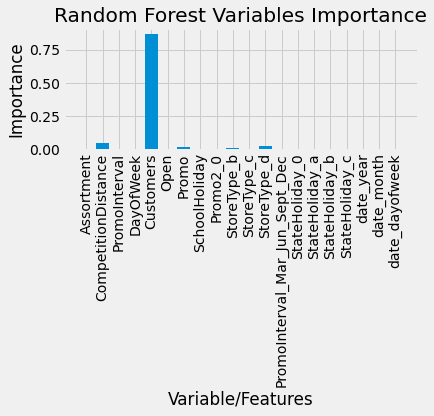

In [23]:
importances=regr.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
#plt.savefig('Random-Forest-Variables-Importances.jpg',dpi=600)
plt.show();

## 3. Deep Learning

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
original_feature=['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

In [27]:
df_check=pd.read_csv(dataset)
df_check.drop('Date',axis=1,inplace=True)
df_check=df_check[list(selected_feat)+['Sales']]

In [28]:
X=df_check
y=df_check['Sales'].values
X.drop('Sales',axis=1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train_dl= torch.from_numpy(X_train.values).float()
y_train_dl = torch.from_numpy(y_train).view(-1,1).float()


X_test_dl= torch.from_numpy(X_test.values).float()
y_test_dl = torch.from_numpy(y_test).view(-1,1).float()

In [30]:
X_train_dl=X_train_dl.to(device)
y_train_dl=y_train_dl.to(device)

X_test_dl=X_test_dl.to(device)
y_test_dl=y_test_dl.to(device)

In [31]:
print(X_train_dl.shape,y_train_dl.shape)
print(X_test_dl.shape,y_test_dl.shape)

torch.Size([813767, 20]) torch.Size([813767, 1])
torch.Size([203442, 20]) torch.Size([203442, 1])


In [32]:
N_h=100
dl_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_dl.shape[1], N_h),    
    #torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    
    torch.nn.Linear(N_h, N_h),    
    #torch.nn.Dropout(0.5),
    torch.nn.ReLU(),

    torch.nn.Linear(N_h, N_h),    
    #torch.nn.Dropout(0.5),
    torch.nn.ReLU(),

    torch.nn.Linear(N_h, N_h),    
    #torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    
    torch.nn.Linear(N_h, 1),
)

In [33]:
opt = torch.optim.Adam(dl_model.parameters(),lr=0.005)
loss_fn = torch.nn.MSELoss()

In [34]:
dl_model=dl_model.to(device)

In [35]:
max_epochs = 1000
loss_arr=[]
for epoch in range(max_epochs):
    
    pred = dl_model(X_train_dl) # look at the entire data in a single shot
    loss = loss_fn(pred, y_train_dl)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    y_train_numpy=pred.cpu().detach().numpy()
    y_pred_numpy=y_train_dl.cpu().detach().numpy()
    
    r2_score_train=round(r2_score(y_train_numpy, y_pred_numpy),4)
    if(epoch % 100==0):
      print('Epoch {}/{} , Loss = {} , R2 Score = {}'.format(epoch,max_epochs,loss.item(),r2_score_train))
    loss_arr.append(loss.item())

Epoch 0/1000 , Loss = 48272048.0 , R2 Score = -300155.7025
Epoch 100/1000 , Loss = 2004233.0 , R2 Score = 0.8437
Epoch 200/1000 , Loss = 2086939.875 , R2 Score = 0.8252
Epoch 300/1000 , Loss = 2218098.5 , R2 Score = 0.8068
Epoch 400/1000 , Loss = 1782728.5 , R2 Score = 0.8629
Epoch 500/1000 , Loss = 1699250.5 , R2 Score = 0.8714
Epoch 600/1000 , Loss = 1630091.5 , R2 Score = 0.8787
Epoch 700/1000 , Loss = 1536433.875 , R2 Score = 0.8835
Epoch 800/1000 , Loss = 1535906.375 , R2 Score = 0.8805
Epoch 900/1000 , Loss = 1371868.125 , R2 Score = 0.8975


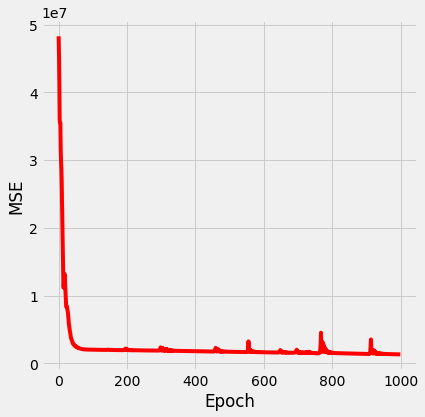

In [36]:
plt.plot(loss_arr, 'r-')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()  

In [37]:
test_pred = dl_model(X_test_dl)
test_loss = loss_fn(test_pred, y_test_dl)
test_pred[test_pred<0]=0

In [38]:
y_pred_numpy=test_pred.cpu().detach().numpy()
y_test_numpy=y_test_dl.cpu().detach().numpy()
print("Test Adj R2 = ",round(adjusted_r2(X_test,r2_score(y_test_numpy, y_pred_numpy)),4))

Test Adj R2 =  0.9123


In [39]:
accuracy.loc['DL']=[r2_score_train,round(adjusted_r2(X_test,r2_score(y_test_numpy, y_pred_numpy)),4)]
print(accuracy)

                 Train Adjusted R2  Test Adjusted R2
LassoRegression             0.8955            0.8967
RFRegressor                 0.9921            0.9812
DL                          0.9028            0.9123


## Accuracy Comparision

In [40]:
accuracy['Train Adjusted R2']=accuracy['Train Adjusted R2']*100
print(accuracy['Train Adjusted R2'])

LassoRegression    89.55
RFRegressor        99.21
DL                 90.28
Name: Train Adjusted R2, dtype: float64


In [41]:
accuracy['Test Adjusted R2']=accuracy['Test Adjusted R2']*100
print(accuracy['Test Adjusted R2'])

LassoRegression    89.67
RFRegressor        98.12
DL                 91.23
Name: Test Adjusted R2, dtype: float64


In [42]:
x=list(range(len(accuracy['Train Adjusted R2'])))
y=list(range(80,101,10))

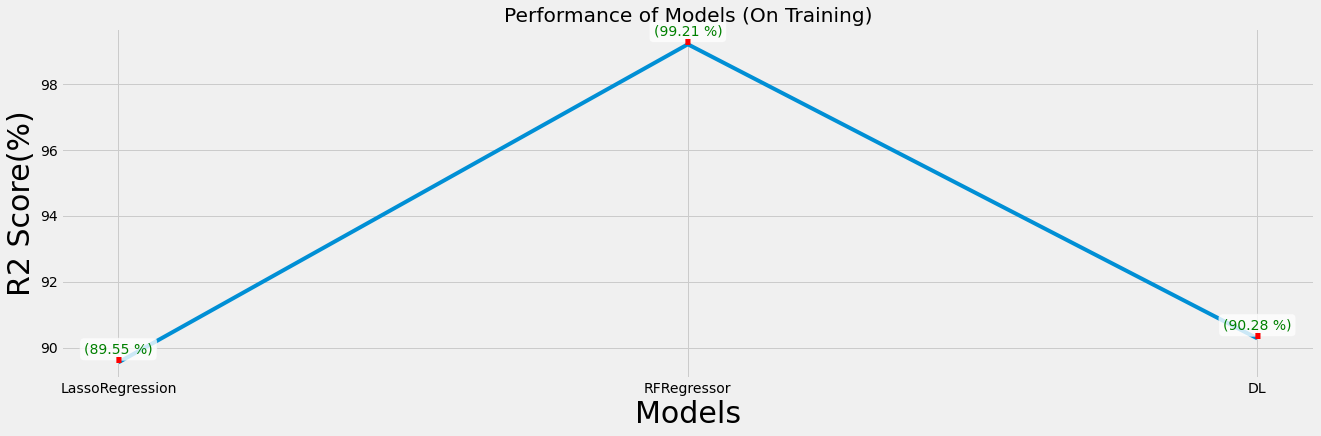

In [43]:
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(accuracy['Train Adjusted R2'])
#plt.yticks(y)
#plt.xticks(fontsize=20)
#plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("R2 Score(%)",fontsize=30)
plt.title("Performance of Models (On Training)")
#plt.text(0, 88, '88',horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
for a,b in zip(x,y):
    b=accuracy.iloc[a]['Train Adjusted R2']
    val="("+str(round(b,2))+" %)"
    plt.text(a, b+0.4, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+0.4, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)

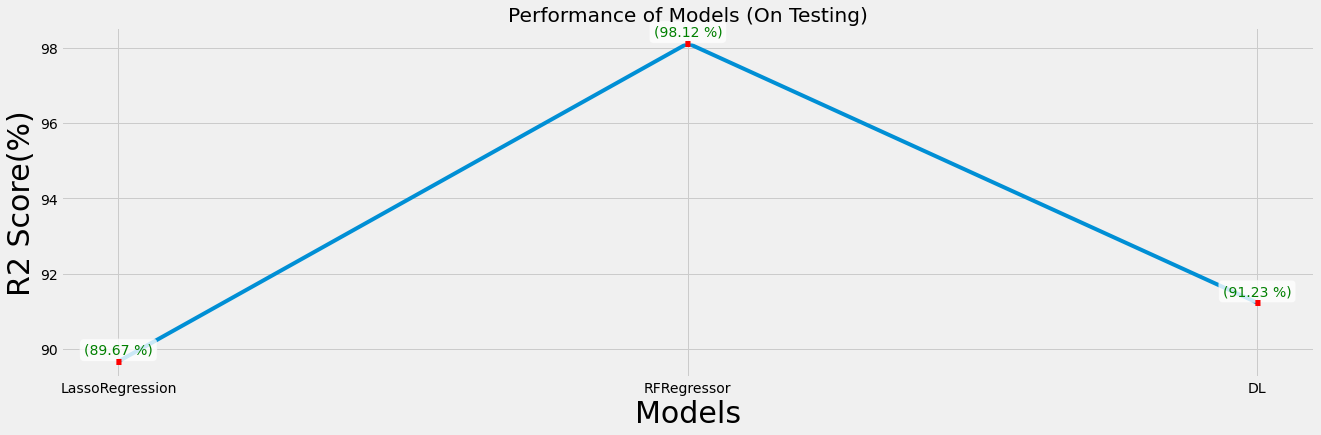

In [44]:

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(accuracy['Test Adjusted R2'])
#plt.yticks(y)
#plt.xticks(fontsize=20)
#plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("R2 Score(%)",fontsize=30)
plt.title("Performance of Models (On Testing)")
#plt.text(0, 88, '88',horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
for a,b in zip(x,y):
    b=accuracy.iloc[a]['Test Adjusted R2']
    val="("+str(round(b,2))+" %)"
    plt.text(a, b+0.3, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+0.3, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)